**Author**: Danny Western; University of Virginia Department of Astronomy

**Summary**
This notebook aims to query two data archives - JWST and ALMA - for observations of any given object. It will then cross-reference the observations found in each archive and plot them by right ascension and declination.

NOTE: Code was included to use the ESO mirror of the ALMA archive due to connection issues. Additional debugging was also added to the ALMA code block, and can be edited and repurposedfor the JWST query as well.

**Imports**

Less common imports

-from urllib.error import URLError: Allows the program to notice if an incorrect URL is used for a data archive

-from astropy.coordinates import SkyCoord: Allows the program to resolve the coordinates of an object given the name

-from astropy import units as u: Imports units such as RA and Dec for the program to use

-from astroquery.mast import Observations: Allows the program to see and list observations from the MAST archive (JWST)

-from astroquery.alma import Alma: Allows the program to see and list observations from the ALMA archive

In [19]:
from urllib.error import URLError
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.mast import Observations
from astroquery.alma import Alma

**JWST Query**

Queries the MAST archive for JWST observations of a given target.

    Args:
        target_name (str): The name of the celestial object to search for.
        radius_arcsec (float): The search radius in arcseconds.

    Returns:
        An astropy.table.Table object containing the JWST observation data,
        or None if no data is found.

In [22]:
def query_jwst(target_name, radius_arcsec):
    print(f"Querying JWST archive for '{target_name}'...")
    try:
        # Perform a cone search for the object
        obs_table = Observations.query_object(target_name, radius=radius_arcsec * u.arcsec)

        # Filter for JWST observations
        jwst_obs = obs_table[obs_table['obs_collection'] == 'JWST']
        
        if len(jwst_obs) > 0:
            print(f"Found {len(jwst_obs)} JWST observations.")
            return jwst_obs
        else:
            print("No JWST observations found for this target.")
            return None
    except Exception as e:
        print(f"An error occurred during the JWST query: {e}")
        return None

**ALMA Query**

Queries the ALMA science archive for observations of a given target.
    
    Args:
        target_name (str): The name of the celestial object to search for.
        radius_arcsec (float): The search radius in arcseconds.
        retries (int): The number of times to retry the query on failure.

    Returns:
        An astropy.table.Table object containing the ALMA observation data,
        or None if no data is found.

In [25]:
def query_alma(target_name, radius_arcsec, retries=3):
    print(f"\nQuerying ALMA archive for '{target_name}'...")
    try:
        # First, resolve the target name into coordinates for the cone search
        target_coords = SkyCoord.from_name(target_name)
        print(f"Resolved '{target_name}' to coordinates: {target_coords.to_string('hmsdms')}")

        # Get an instance of the Alma tool
        alma = Alma()
        
        # Switch to the European (ESO) mirror to bypass server errors
        print("Using the ESO (European) ALMA archive mirror.")
        alma.archive_mirror = 'ESO'

        # --- Retry logic for network errors ---
        for attempt in range(retries):
            try:
                # Perform a cone search using query_region with the resolved coordinates
                search_radius = radius_arcsec * u.arcsec
                alma_obs = alma.query_region(target_coords, radius=search_radius, public=True)

                if alma_obs and len(alma_obs) > 0:
                    print(f"\nFound {len(alma_obs)} public ALMA observations.")
                    return alma_obs
                else:
                    print("\nNo public ALMA observations found for this target in the specified radius.")
                    return None

            except (URLError, TimeoutError, ConnectionResetError) as e:
                print(f"Network error on attempt {attempt + 1}: {e}")
                if attempt < retries - 1:
                    wait_time = 5 * (attempt + 1) # Wait longer each time
                    print(f"Waiting {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                else:
                    print("Max retries reached. ALMA query failed.")
                    raise e # Re-raise the last exception
        
        return None # Should only be reached if all retries fail without raising

    except Exception as e:
        print(f"An unrecoverable error occurred during the ALMA query: {e}")
        return None

**Plot Data**

Creates a plot to visualize and compare the JWST and ALMA data.
    This example plots the sky coverage of the observations.

    Args:
        jwst_results (astropy.table.Table): Table of JWST observations.
        alma_results (astropy.table.Table): Table of ALMA observations.
        target_name (str): The name of the target object for the plot title.

In [28]:
def plot_data(jwst_results, alma_results, target_name):
    if jwst_results is None and alma_results is None:
        print("\nNo data to plot.")
        return

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot JWST data if available
    if jwst_results is not None:
        ax.scatter(jwst_results['s_ra'], jwst_results['s_dec'], 
                   alpha=0.7, edgecolors='cyan', c='none',
                   label='JWST Observations', marker='o', s=150, linewidths=1.5)

    # Plot ALMA data if available
    if alma_results is not None:
        # The coordinate columns in ALMA results are 'RA' and 'DEC' (all caps)
        if 's_ra' in alma_results.colnames and 's_dec' in alma_results.colnames:
            ax.scatter(alma_results['s_ra'], alma_results['s_dec'], 
                       alpha=0.7, edgecolors='orange', c='none',
                       label='ALMA Observations', marker='s', s=150, linewidths=1.5)
        else:
            print("ALMA results table is missing 'RA' or 'DEC' columns.")

    # Get coordinates of the target for centering the plot
    try:
        target_coords = SkyCoord.from_name(target_name)
        ax.scatter(target_coords.ra.deg, target_coords.dec.deg, 
                   color='red', marker='*', s=250, label=f'Target: {target_name}', zorder=5)
    except Exception as e:
        print(f"Could not resolve coordinates for target '{target_name}': {e}")


    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title(f'JWST and ALMA Observations of {target_name}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)

    # Invert RA axis
    ax.invert_xaxis()

    plt.show()

**Main Function**

Conducts both queries and completes the cross-reference to plot all found observations from both ALMA and JWST

Querying JWST archive for 'M33'...
Found 24 JWST observations.

Querying ALMA archive for 'M33'...
Resolved 'M33' to coordinates: 01h33m50.89657492s +30d39m36.63040313s
Using the ESO (European) ALMA archive mirror.

Found 247 public ALMA observations.

--- Cross-Reference Summary ---
JWST Instruments used: instrument_name
---------------
     MIRI/IMAGE
   NIRCAM/IMAGE
ALMA Bands used: band_list
---------
        3
        6


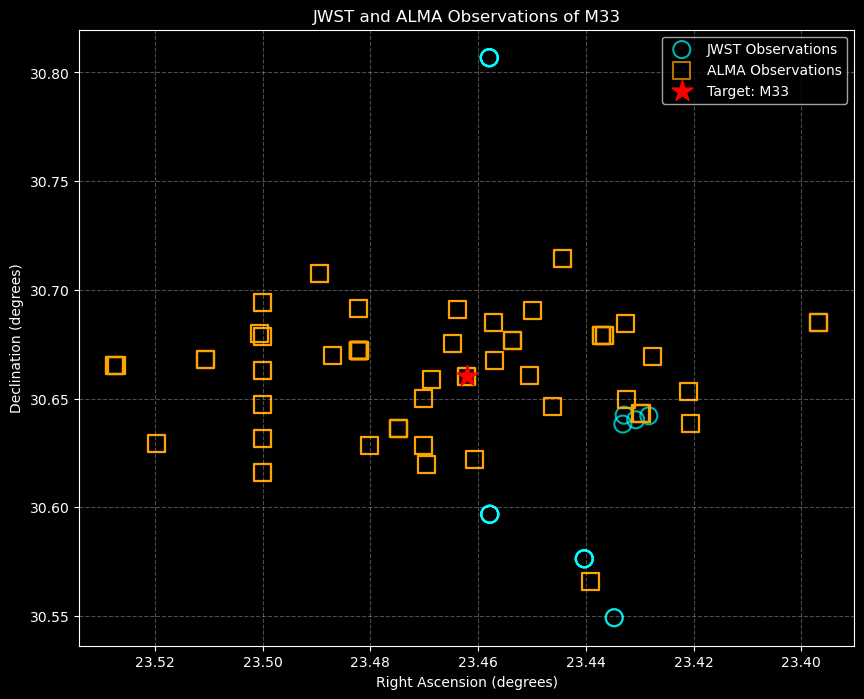

In [31]:
if __name__ == '__main__':
    # --- User Input --- Change TARGET_OBJECT to desired object
    TARGET_OBJECT = 'M33'
    SEARCH_RADIUS_ARCSEC = 120  # 2 arcminutes, can change this if more datapoints are desired

    # --- Query Telescopes ---
    jwst_data = query_jwst(TARGET_OBJECT, SEARCH_RADIUS_ARCSEC)
    alma_data = query_alma(TARGET_OBJECT, SEARCH_RADIUS_ARCSEC)

    # --- Cross-Reference and Analyze ---
    # This is a simple printout, but this can be expanded to perform more data analysis tasks
    # to perform more complex data analysis.
    print("\n--- Cross-Reference Summary ---")
    if jwst_data is not None:
        print(f"JWST Instruments used: {np.unique(jwst_data['instrument_name'])}")
    if alma_data is not None:
        print(f"ALMA Bands used: {np.unique(alma_data['band_list'])}")

    # --- Plot the Data ---
    plot_data(jwst_data, alma_data, TARGET_OBJECT)

Querying JWST archive for 'M42'...
Found 1797 JWST observations.

Querying ALMA archive for 'M42'...
Resolved 'M42' to coordinates: 05h35m16.824s -05d23m15.36s
Using the ESO (European) ALMA archive mirror.

Found 712 public ALMA observations.

--- Cross-Reference Summary ---
JWST Instruments used: instrument_name
---------------
       MIRI/IFU
     MIRI/IMAGE
   NIRCAM/IMAGE
    NIRSPEC/IFU
    NIRSPEC/MSA
ALMA Bands used: band_list
---------
        1
       10
        3
      3 6
        4
        5
        6
        7
        8
        9


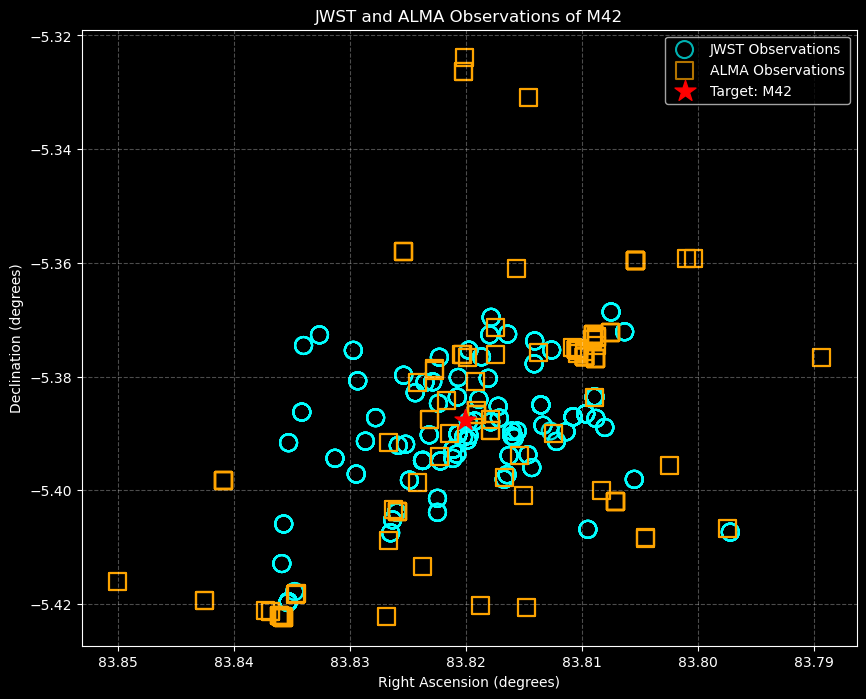

In [41]:
# --- Imports ---
from urllib.error import URLError
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.mast import Observations
from astroquery.alma import Alma
import time

# --- JWST Query Function ---
def query_jwst(target_name, radius_arcsec):
    """
    Queries the MAST archive for JWST observations of a given target.

    Args:
        target_name (str): The name of the celestial object to search for.
        radius_arcsec (float): The search radius in arcseconds.

    Returns:
        An astropy.table.Table object containing the JWST observation data,
        or None if no data is found.
    """
    print(f"Querying JWST archive for '{target_name}'...")
    try:
        # Perform a cone search for the object
        obs_table = Observations.query_object(target_name, radius=radius_arcsec * u.arcsec)

        # Filter for JWST observations
        jwst_obs = obs_table[obs_table['obs_collection'] == 'JWST']
        
        if len(jwst_obs) > 0:
            print(f"Found {len(jwst_obs)} JWST observations.")
            return jwst_obs
        else:
            print("No JWST observations found for this target.")
            return None
    except Exception as e:
        print(f"An error occurred during the JWST query: {e}")
        return None

# --- ALMA Query Function ---
def query_alma(target_name, radius_arcsec, retries=3):
    """
    Queries the ALMA science archive for observations of a given target.
    
    Args:
        target_name (str): The name of the celestial object to search for.
        radius_arcsec (float): The search radius in arcseconds.
        retries (int): The number of times to retry the query on failure.

    Returns:
        An astropy.table.Table object containing the ALMA observation data,
        or None if no data is found.
    """
    print(f"\nQuerying ALMA archive for '{target_name}'...")
    try:
        # First, resolve the target name into coordinates for the cone search
        target_coords = SkyCoord.from_name(target_name)
        print(f"Resolved '{target_name}' to coordinates: {target_coords.to_string('hmsdms')}")

        # Get an instance of the Alma tool
        alma = Alma()
        
        # Switch to the European (ESO) mirror to bypass server errors
        print("Using the ESO (European) ALMA archive mirror.")
        alma.archive_mirror = 'ESO'

        # --- Retry logic for network errors ---
        for attempt in range(retries):
            try:
                # Perform a cone search using query_region with the resolved coordinates
                search_radius = radius_arcsec * u.arcsec
                alma_obs = alma.query_region(target_coords, radius=search_radius, public=True)

                if alma_obs and len(alma_obs) > 0:
                    print(f"\nFound {len(alma_obs)} public ALMA observations.")
                    return alma_obs
                else:
                    print("\nNo public ALMA observations found for this target in the specified radius.")
                    return None

            except (URLError, TimeoutError, ConnectionResetError) as e:
                print(f"Network error on attempt {attempt + 1}: {e}")
                if attempt < retries - 1:
                    wait_time = 5 * (attempt + 1) # Wait longer each time
                    print(f"Waiting {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                else:
                    print("Max retries reached. ALMA query failed.")
                    raise e # Re-raise the last exception
        
        return None # Should only be reached if all retries fail without raising

    except Exception as e:
        print(f"An unrecoverable error occurred during the ALMA query: {e}")
        return None

# --- Plotting Function ---
def plot_data(jwst_results, alma_results, target_name):
    """
    Creates a plot to visualize and compare the JWST and ALMA data.
    This example plots the sky coverage of the observations.

    Args:
        jwst_results (astropy.table.Table): Table of JWST observations.
        alma_results (astropy.table.Table): Table of ALMA observations.
        target_name (str): The name of the target object for the plot title.
    """
    if jwst_results is None and alma_results is None:
        print("\nNo data to plot.")
        return

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot JWST data if available
    if jwst_results is not None:
        ax.scatter(jwst_results['s_ra'], jwst_results['s_dec'], 
                   alpha=0.7, edgecolors='cyan', c='none',
                   label='JWST Observations', marker='o', s=150, linewidths=1.5)

    # Plot ALMA data if available
    if alma_results is not None:
        # The coordinate columns in ALMA results are 's_ra' and 's_dec'
        if 's_ra' in alma_results.colnames and 's_dec' in alma_results.colnames:
            ax.scatter(alma_results['s_ra'], alma_results['s_dec'], 
                       alpha=0.7, edgecolors='orange', c='none',
                       label='ALMA Observations', marker='s', s=150, linewidths=1.5)
        else:
            print("ALMA results table is missing 's_ra' or 's_dec' columns.")

    # Get coordinates of the target for centering the plot
    try:
        target_coords = SkyCoord.from_name(target_name)
        ax.scatter(target_coords.ra.deg, target_coords.dec.deg, 
                   color='red', marker='*', s=250, label=f'Target: {target_name}', zorder=5)
    except Exception as e:
        print(f"Could not resolve coordinates for target '{target_name}': {e}")


    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title(f'JWST and ALMA Observations of {target_name}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)

    # Invert RA axis
    ax.invert_xaxis()

    plt.show()

# --- Main Execution Block ---
if __name__ == '__main__':
    # --- User Input --- Change TARGET_OBJECT to desired object
    TARGET_OBJECT = 'M42'
    SEARCH_RADIUS_ARCSEC = 120  # 2 arcminutes, can change this if more datapoints are desired

    # --- Query Telescopes ---
    jwst_data = query_jwst(TARGET_OBJECT, SEARCH_RADIUS_ARCSEC)
    alma_data = query_alma(TARGET_OBJECT, SEARCH_RADIUS_ARCSEC)

    # --- Cross-Reference and Analyze ---
    print("\n--- Cross-Reference Summary ---")
    if jwst_data is not None:
        print(f"JWST Instruments used: {np.unique(jwst_data['instrument_name'])}")
    if alma_data is not None:
        print(f"ALMA Bands used: {np.unique(alma_data['band_list'])}")

    # --- Plot the Data ---
    plot_data(jwst_data, alma_data, TARGET_OBJECT)